# Weighted incidents (priority-based routing)

Incidents now have priority weights from {1, 2, 4, 8, 16} representing severity levels. The objective function uses distance/weight, so high-priority (high-weight) incidents have LOWER cost
  and are served faster.

  - Weight 16 (critical): cost = distance/16 (highest priority)
  - Weight 8 (high): cost = distance/8
  - Weight 4 (medium): cost = distance/4
  - Weight 2 (low): cost = distance/2
  - Weight 1 (routine): cost = distance/1 (lowest priority)

In [1]:
# --- cell: setup ---
# Core
import math, time, random
from collections import defaultdict

# Data
import numpy as np
import pandas as pd

# Modeling
import pulp as pl

# Pretty printing
from dataclasses import dataclass

np.random.seed(42)
random.seed(42)

print("PuLP version:", pl.__version__)

PuLP version: 3.3.0


In [2]:
# --- cell: solver detection ---
def get_available_solvers():
    """Return a dict of {name: pulp_solver_instance} for locally available solvers."""
    candidates = []
    
    # CBC (bundled with PuLP in many environments)
    try:
        candidates.append(("CBC", pl.PULP_CBC_CMD(msg=False)))
    except Exception:
        pass
    
    # GLPK (requires glpsol in PATH)
    try:
        candidates.append(("GLPK", pl.GLPK_CMD(msg=False)))
    except Exception:
        pass
    
    # CPLEX (requires cplex to be installed & licensed)
    try:
        candidates.append(("CPLEX", pl.CPLEX_CMD(msg=False)))
    except Exception:
        pass
    
    # Gurobi (requires gurobi & license)
    try:
        candidates.append(("Gurobi", pl.GUROBI_CMD(msg=False)))
    except Exception:
        pass
    
    # SCIP (requires scip)
    try:
        candidates.append(("SCIP", pl.SCIP_CMD(msg=False)))
    except Exception:
        pass
    
    # Filter to actually working by calling .path or try a quick build
    available = {}
    for name, solver in candidates:
        try:
            # Many PuLP solver wrappers expose .path or succeed if we try a tiny LP
            test = pl.LpProblem("test", pl.LpMinimize)
            x = pl.LpVariable("x", 0)
            test += x
            status = test.solve(solver)
            if pl.LpStatus[status] != "Infeasible":  # Should be Optimal with x=0
                available[name] = solver
        except Exception:
            pass
    
    return available

solvers = get_available_solvers()
print("Detected solvers:", list(solvers.keys()) or "(none found)")


Detected solvers: ['CBC']


## Dataclass with weights

In [3]:
import math

def coord_distance(origins: list[tuple[float, float]], 
                         destinations: list[tuple[float, float]],
                         mode: str = "driving") -> dict:
    """
    Mock Google Maps Distance Matrix API using Euclidean distance.
    
    Args:
        origins: List of (lat, lng) tuples
        destinations: List of (lat, lng) tuples
        mode: Travel mode (ignored, but kept for interface compatibility)
    
    Returns:
        Response dict matching Google Maps API structure
    """
    
    def euclidean_distance_km(origin: tuple[float, float], 
                               destination: tuple[float, float]) -> float:
        """Calculate Euclidean distance in km (approximate, using lat/lng)."""
        lat1, lng1 = origin
        lat2, lng2 = destination
        
        # Rough conversion: 1 degree lat ≈ 111 km, 1 degree lng ≈ 111 km * cos(lat)
        avg_lat = math.radians((lat1 + lat2) / 2)
        
        delta_lat_km = (lat2 - lat1) * 111
        delta_lng_km = (lng2 - lng1) * 111 * math.cos(avg_lat)
        
        return math.sqrt(delta_lat_km**2 + delta_lng_km**2)
    
    def estimate_duration(distance_km: float) -> int:
        """Estimate travel time in seconds (assuming ~40 km/h average)."""
        return int(distance_km / 40 * 3600)
    
    rows = []
    for origin in origins:
        elements = []
        for destination in destinations:
            distance_km = euclidean_distance_km(origin, destination)
            distance_m = int(distance_km * 1000)
            duration_s = estimate_duration(distance_km)
            
            elements.append({
                "distance": {
                    "text": f"{distance_km:.1f} km",
                    "value": distance_m
                },
                "duration": {
                    "text": f"{duration_s // 60} mins",
                    "value": duration_s
                },
                "status": "OK"
            })
        
        rows.append({"elements": elements})
    
    return {
        "destination_addresses": [f"{lat}, {lng}" for lat, lng in destinations],
        "origin_addresses": [f"{lat}, {lng}" for lat, lng in origins],
        "rows": rows,
        "status": "OK"
    }


# Example usage
if __name__ == "__main__":
    origins = [(43.4723, -80.5449)]  # Waterloo
    destinations = [(43.6532, -79.3832)]  # Toronto
    
    result = coord_distance(origins, destinations)
    
    print(f"Distance: {result['rows'][0]['elements'][0]['distance']['text']}")
    print(f"Duration: {result['rows'][0]['elements'][0]['duration']['text']}")

Distance: 95.6 km
Duration: 143 mins


In [4]:
@dataclass
class WeightedInstance:
    coords_ambulances: np.ndarray  # shape (A, 2) - (lat, lng) pairs
    coords_incidents: np.ndarray   # shape (N, 2) - (lat, lng) pairs
    weights: np.ndarray            # shape (N,) - priority weights for each incident
    A: int
    N: int
    dist_a_to_i: np.ndarray        # shape (A, N) - distances in km
    dist_i_to_i: np.ndarray        # shape (N, N) - distances in km

def make_weighted_instance(
    A=3, N=8, 
    lat_range=(43.25, 43.70),      # Waterloo region latitude range
    lng_range=(-80.85, -80.20),     # Waterloo region longitude range
    weight_choices=[1, 2, 4, 8, 16],
    rng_seed=None
) -> WeightedInstance:
    """Generate lat/lng coordinates for ambulances & incidents with priority weights."""
    if rng_seed is not None:
        np.random.seed(rng_seed)

    # Generate random lat/lng coordinates within the Waterloo region
    lat_min, lat_max = lat_range
    lng_min, lng_max = lng_range

    # Ambulances: (lat, lng) pairs
    amb_lats = np.random.uniform(lat_min, lat_max, A)
    amb_lngs = np.random.uniform(lng_min, lng_max, A)
    coords_ambulances = np.column_stack([amb_lats, amb_lngs])

    # Incidents: (lat, lng) pairs
    inc_lats = np.random.uniform(lat_min, lat_max, N)
    inc_lngs = np.random.uniform(lng_min, lng_max, N)
    coords_incidents = np.column_stack([inc_lats, inc_lngs])

    # Assign random weights
    weights = np.random.choice(weight_choices, size=N)

    # Compute distance matrices using coord_distance
    # A -> I distances
    d_ai = np.zeros((A, N))
    for a in range(A):
        origins = [(coords_ambulances[a, 0], coords_ambulances[a, 1])]
        destinations = [(coords_incidents[i, 0], coords_incidents[i, 1]) for i in range(N)]
        result = coord_distance(origins, destinations)
        for i in range(N):
            # Extract distance in meters and convert to km
            d_ai[a, i] = result['rows'][0]['elements'][i]['distance']['value'] / 1000.0

    # I -> I distances
    d_ii = np.zeros((N, N))
    for i in range(N):
        origins = [(coords_incidents[i, 0], coords_incidents[i, 1])]
        destinations = [(coords_incidents[j, 0], coords_incidents[j, 1]) for j in range(N)]
        result = coord_distance(origins, destinations)
        for j in range(N):
            d_ii[i, j] = result['rows'][0]['elements'][j]['distance']['value'] / 1000.0

    return WeightedInstance(
        coords_ambulances, coords_incidents, weights, A, N, d_ai, d_ii
    )

In [5]:
# Create a weighted instance with real Waterloo region coordinates
inst_w = make_weighted_instance(
    A=3,
    N=8,
    lat_range=(43.25, 43.70),    # Waterloo region latitude
    lng_range=(-80.85, -80.20),   # Waterloo region longitude
    rng_seed=42
)

print(f"A={inst_w.A}, N={inst_w.N}")
print(f"Incident weights: {inst_w.weights}")
print(f"\nAmbulance coordinates (lat, lng):")
for a in range(inst_w.A):
    print(f"  A{a}: ({inst_w.coords_ambulances[a, 0]:.4f}, {inst_w.coords_ambulances[a, 1]:.4f})")

A=3, N=8
Incident weights: [ 8  8  4  8  8  1  4 16]

Ambulance coordinates (lat, lng):
  A0: (43.4185, -80.4609)
  A1: (43.6778, -80.7486)
  A2: (43.5794, -80.7486)


## Weighted multi-round dispatch with hospitals

In [6]:
def build_k_assignment(cost_AxN: np.ndarray, k: int):
    """
    Build a k-assignment ILP (choose exactly k pairs) on cost matrix (A x N).
    Constraints:
      - each ambulance used at most once
      - each incident served at most once
      - total assigned equals k
    """
    A, N = cost_AxN.shape
    assert 0 <= k <= min(A, N), "k must be <= min(A, N)"
    
    m = pl.LpProblem("k_assignment", pl.LpMinimize)
    x = pl.LpVariable.dicts("x", (range(A), range(N)), 0, 1, pl.LpBinary)

    # Objective
    m += pl.lpSum(cost_AxN[a, i] * x[a][i] for a in range(A) for i in range(N))

    # Each ambulance at most one
    for a in range(A):
        m += pl.lpSum(x[a][i] for i in range(N)) <= 1, f"cap_ambulance_{a}"

    # Each incident at most one
    for i in range(N):
        m += pl.lpSum(x[a][i] for a in range(A)) <= 1, f"cap_incident_{i}"

    # Exactly k assignments
    m += pl.lpSum(x[a][i] for a in range(A) for i in range(N)) == k, "exact_k"

    return m, x

In [7]:
# Hospitals

def make_hospitals(num_hospitals=2, 
                    lat_range=(43.25, 43.70), 
                    lng_range=(-80.85, -80.20), 
                    rng_seed=None):
    """Generate hospital lat/lng coordinates within the Waterloo region."""
    rng = np.random.default_rng(rng_seed)

    lat_min, lat_max = lat_range
    lng_min, lng_max = lng_range

    lats = rng.uniform(lat_min, lat_max, num_hospitals)
    lngs = rng.uniform(lng_min, lng_max, num_hospitals)

    return np.column_stack([lats, lngs])

def nearest_hospital(incident_latlong, hospitals_latlong):
    """
    Find nearest hospital to an incident using coord_distance.
    
    Args:
        incident_latlong: (lat, lng) tuple
        hospitals_latlong: numpy array of shape (H, 2) with (lat, lng) pairs
    
    Returns:
        (hospital_index, distance_in_km)
    """
    origins = [tuple(incident_latlong)]
    destinations = [(hospitals_latlong[h, 0], hospitals_latlong[h, 1])
                    for h in range(len(hospitals_latlong))]

    result = coord_distance(origins, destinations)

    # Find minimum distance hospital
    min_dist_km = float('inf')
    min_idx = 0

    for h in range(len(hospitals_latlong)):
        dist_m = result['rows'][0]['elements'][h]['distance']['value']
        dist_km = dist_m / 1000.0
        if dist_km < min_dist_km:
            min_dist_km = dist_km
            min_idx = h

    return min_idx, min_dist_km

In [8]:
# --- cell: weighted multi-round dispatch with hospitals ---
from collections import defaultdict
import numpy as np
import pulp as pl

def run_weighted_dispatch_with_hospitals(inst_w, hospitals, solver=None, jitter=0.0, verbose=True):
      """
      Multi-round assignment with weighted incidents where each service consists of:
      ambulance -> incident -> hospital (nearest)
      
      Uses coord_distance for realistic travel distances in km.
      The cost is: (dist_to_incident + dist_to_hospital) / weight[incident]
      Higher weight = LOWER cost = higher priority.
      """
      if solver is None:
          solver = pl.PULP_CBC_CMD(msg=False)

      A = inst_w.A
      remaining = list(range(inst_w.N))
      amb_pos = inst_w.coords_ambulances.copy()  # Current ambulance positions (lat, lng)

      routes_inc = defaultdict(list)
      routes_hosp = defaultdict(list)
      legs = defaultdict(list)
      total_weighted_cost = 0.0
      total_unweighted_distance = 0.0
      round_id = 0
      round_summaries = []

      while remaining:
          round_id += 1
          k = min(A, len(remaining))

          # Build WEIGHTED composite cost using coord_distance
          cost = np.zeros((A, len(remaining)), dtype=float)
          chosen_hospital = [[None]*len(remaining) for _ in range(A)]

          for a in range(A):
              # Compute ambulance -> all remaining incidents
              origins = [(amb_pos[a, 0], amb_pos[a, 1])]
              destinations = [(inst_w.coords_incidents[j, 0], inst_w.coords_incidents[j, 1])
                             for j in remaining]

              result_a_to_i = coord_distance(origins, destinations)

              for col, j in enumerate(remaining):
                  # Distance from ambulance to incident (in km)
                  amb_to_inc = result_a_to_i['rows'][0]['elements'][col]['distance']['value'] / 1000.0

                  # Find nearest hospital from this incident
                  h_idx, inc_to_h = nearest_hospital(inst_w.coords_incidents[j], hospitals)

                  # Weighted cost: distance / weight (higher weight = lower cost = higher priority)
                  unweighted_dist = amb_to_inc + inc_to_h
                  weighted_cost = unweighted_dist / inst_w.weights[j]

                  cost[a, col] = weighted_cost + (np.random.uniform(0, jitter) if jitter>0 else 0.0)
                  chosen_hospital[a][col] = (h_idx, amb_to_inc, inc_to_h, unweighted_dist)

          # Solve k-assignment
          m, x = build_k_assignment(cost, k)
          status = m.solve(solver)
          if pl.LpStatus[status] != "Optimal":
              raise RuntimeError(f"Round {round_id}: solver returned {pl.LpStatus[status]}")

          # Apply assignments
          served_this_round = set()
          round_weighted_cost = 0.0
          round_unweighted_dist = 0.0
          round_assignments = []

          for a in range(A):
              for col, j in enumerate(remaining):
                  if (x[a][col].value() or 0) > 0.5:
                      h_idx, amb_to_inc, inc_to_h, unweighted_dist = chosen_hospital[a][col]
                      weight = inst_w.weights[j]

                      # leg 1: ambulance -> incident
                      start_latlong = amb_pos[a].copy()
                      inc_latlong = inst_w.coords_incidents[j].copy()
                      legs[a].append((start_latlong, inc_latlong, "to_incident"))

                      # leg 2: incident -> hospital
                      hosp_latlong = hospitals[h_idx].copy()
                      legs[a].append((inc_latlong, hosp_latlong, "to_hospital"))

                      # Update ambulance position to hospital
                      amb_pos[a] = hosp_latlong
                      routes_inc[a].append(j)
                      routes_hosp[a].append(h_idx)
                      served_this_round.add(j)

                      weighted_cost = unweighted_dist / weight
                      total_weighted_cost += weighted_cost
                      total_unweighted_distance += unweighted_dist
                      round_weighted_cost += weighted_cost
                      round_unweighted_dist += unweighted_dist

                      round_assignments.append((a, j, float(weighted_cost), float(unweighted_dist), int(weight)))

          remaining = [j for j in remaining if j not in served_this_round]
          round_summaries.append({
              "round": round_id,
              "assignments": round_assignments,
              "round_weighted_cost": round_weighted_cost,
              "round_unweighted_dist": round_unweighted_dist,
              "remaining_after": len(remaining),
          })

          if verbose:
              print(f"Round {round_id}: weighted_cost={round_weighted_cost:.3f}, "
                    f"unweighted_dist={round_unweighted_dist:.3f} km, "
                    f"served={len(round_assignments)}, remaining={len(remaining)}")

      return {
          "routes_incidents": routes_inc,
          "routes_hospitals": routes_hosp,
          "legs": legs,
          "rounds": round_summaries,
          "total_weighted_cost": total_weighted_cost,
          "total_unweighted_distance": total_unweighted_distance,
      }

## Run weighted example

In [9]:
# Create a weighted instance with real Waterloo region coordinates
inst_w = make_weighted_instance(
    A=3,
    N=8,
    lat_range=(43.25, 43.70),    # Waterloo region
    lng_range=(-80.85, -80.20),   # Waterloo region
    rng_seed=42
)

print(f"A={inst_w.A}, N={inst_w.N}")
print(f"Incident weights: {inst_w.weights}")
print(f"\nAmbulance coordinates (lat, lng):")
for a in range(inst_w.A):
    print(f"  A{a}: ({inst_w.coords_ambulances[a, 0]:.4f}, {inst_w.coords_ambulances[a, 1]:.4f})")
print(f"\nIncident coordinates (lat, lng):")
for i in range(inst_w.N):
    print(f"  I{i}: ({inst_w.coords_incidents[i, 0]:.4f}, {inst_w.coords_incidents[i, 1]:.4f}) [weight={inst_w.weights[i]}]")

A=3, N=8
Incident weights: [ 8  8  4  8  8  1  4 16]

Ambulance coordinates (lat, lng):
  A0: (43.4185, -80.4609)
  A1: (43.6778, -80.7486)
  A2: (43.5794, -80.7486)

Incident coordinates (lat, lng):
  I0: (43.2761, -80.7318) [weight=8]
  I1: (43.6398, -80.7308) [weight=8]
  I2: (43.5205, -80.6522) [weight=4]
  I3: (43.5686, -80.5089) [weight=8]
  I4: (43.2593, -80.5692) [weight=8]
  I5: (43.6865, -80.6607) [weight=1]
  I6: (43.6246, -80.4523) [weight=4]
  I7: (43.3456, -80.7593) [weight=16]


In [10]:
# Generate hospitals in Waterloo region
hospitals = make_hospitals(
    num_hospitals=2,
    lat_range=(43.25, 43.70),
    lng_range=(-80.85, -80.20),
    rng_seed=7
)

print("Hospital coordinates (lat, lng):")
for h in range(len(hospitals)):
    print(f"  H{h}: ({hospitals[h, 0]:.4f}, {hospitals[h, 1]:.4f})")

# Choose solver
if 'solvers' in globals() and solvers:
    chosen_name, chosen_solver = next(iter(solvers.items()))
else:
    chosen_name, chosen_solver = "CBC", pl.PULP_CBC_CMD(msg=False)

print(f"\nUsing solver: {chosen_name}")
print(f"Incident weights: {inst_w.weights}\n")

outH_weighted = run_weighted_dispatch_with_hospitals(
    inst_w, hospitals, solver=chosen_solver, verbose=True
)

print(f"\nTotal weighted cost: {outH_weighted['total_weighted_cost']:.3f}")
print(f"Total unweighted distance: {outH_weighted['total_unweighted_distance']:.3f} km")

# Show routing details
for a in range(inst_w.A):
    incident_list = outH_weighted['routes_incidents'][a]
    weights_list = [inst_w.weights[i] for i in incident_list]
    print(f"Ambulance {a}: incidents {incident_list} with weights {weights_list}")

Hospital coordinates (lat, lng):
  H0: (43.5313, -80.3458)
  H1: (43.6537, -80.7036)

Using solver: CBC
Incident weights: [ 8  8  4  8  8  1  4 16]

Round 1: weighted_cost=8.529, unweighted_dist=98.471 km, served=3, remaining=5
Round 2: weighted_cost=24.407, unweighted_dist=67.598 km, served=3, remaining=2
Round 3: weighted_cost=19.285, unweighted_dist=154.280 km, served=2, remaining=0

Total weighted cost: 52.221
Total unweighted distance: 320.349 km
Ambulance 0: incidents [3, 6, 4] with weights [8, 4, 8]
Ambulance 1: incidents [1, 5, 0] with weights [8, 1, 8]
Ambulance 2: incidents [7, 2] with weights [16, 4]


## Visualization with weights

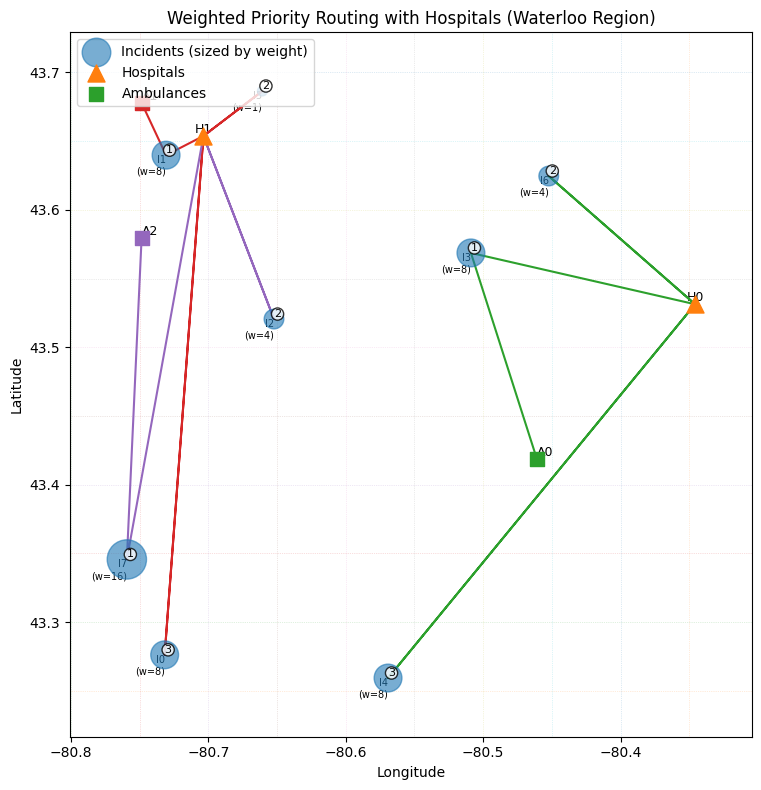

In [11]:
# --- cell: visualize weighted routes with lat/lng ---
import matplotlib.pyplot as plt
import numpy as np

def plot_weighted_routes_with_hospitals(inst_w, hospitals, outH, title="Weighted Multi-round with Hospitals"):
    amb0 = inst_w.coords_ambulances  # (lat, lng) pairs
    inc  = inst_w.coords_incidents   # (lat, lng) pairs
    weights = inst_w.weights
    H    = hospitals  # (lat, lng) pairs

    fig, ax = plt.subplots(figsize=(10, 8))

    # Calculate bounds
    all_lats = np.concatenate([amb0[:, 0], inc[:, 0], H[:, 0]])
    all_lngs = np.concatenate([amb0[:, 1], inc[:, 1], H[:, 1]])

    lat_min, lat_max = all_lats.min(), all_lats.max()
    lng_min, lng_max = all_lngs.min(), all_lngs.max()

    # Add padding (in degrees)
    lat_pad = (lat_max - lat_min) * 0.1 or 0.02
    lng_pad = (lng_max - lng_min) * 0.1 or 0.02

    lat_min -= lat_pad
    lat_max += lat_pad
    lng_min -= lng_pad
    lng_max += lng_pad

    # Optional: Draw light grid (every 0.05 degrees ~ 5.5 km)
    lat_grid_step = 0.05
    lng_grid_step = 0.05

    for lat in np.arange(np.floor(lat_min / lat_grid_step) * lat_grid_step,
                        lat_max, lat_grid_step):
        ax.plot([lng_min, lng_max], [lat, lat], linestyle=':', linewidth=0.5, alpha=0.3)

    for lng in np.arange(np.floor(lng_min / lng_grid_step) * lng_grid_step,
                        lng_max, lng_grid_step):
        ax.plot([lng, lng], [lat_min, lat_max], linestyle=':', linewidth=0.5, alpha=0.3)

    # Incidents with size proportional to weight
    sizes = weights * 50
    ax.scatter(inc[:, 1], inc[:, 0], marker='o', s=sizes, alpha=0.6,
                label='Incidents (sized by weight)', zorder=5)
    for i in range(len(inc)):
        ax.text(inc[i, 1], inc[i, 0], f"I{i}\n(w={weights[i]})",
                va='top', ha='right', fontsize=7)

    # Hospitals
    ax.scatter(H[:, 1], H[:, 0], marker='^', s=150, label='Hospitals', zorder=5)
    for h in range(len(H)):
        ax.text(H[h, 1], H[h, 0], f"H{h}", va='bottom', ha='center', fontsize=9)

    # Ambulances & routes
    for a in range(inst_w.A):
        # Build path from legs
        path_pts = [amb0[a]]
        for frm, to, kind in outH["legs"][a]:
            path_pts.append(to)

        if len(path_pts) > 1:
            path_pts = np.array(path_pts)
            # Plot route (lng on x-axis, lat on y-axis)
            ax.plot(path_pts[:, 1], path_pts[:, 0], linestyle='-', linewidth=1.5, zorder=3)

            # Number visits at incident locations (every other leg is to_incident)
            step = 1
            for idx, (frm, to, kind) in enumerate(outH["legs"][a]):
                if kind == "to_incident":
                    ax.text(to[1], to[0], f"{step}", va='bottom', ha='left', fontsize=8,
                            bbox=dict(boxstyle='circle,pad=0.1', facecolor='white',
                                    alpha=0.8, edgecolor='black'), zorder=6)
                    step += 1

        # Plot ambulance start position
        ax.scatter([amb0[a, 1]], [amb0[a, 0]], marker='s', s=100,
                label='Ambulances' if a == 0 else None, zorder=5)
        ax.text(amb0[a, 1], amb0[a, 0], f"A{a}", va='bottom', ha='left', fontsize=9)

    ax.set_xlim(lng_min, lng_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.legend(loc='upper left')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(False)  # We already have our custom grid
    plt.tight_layout()
    plt.show()

plot_weighted_routes_with_hospitals(inst_w, hospitals, outH_weighted,
                                    title="Weighted Priority Routing with Hospitals (Waterloo Region)")

## Animation with weights

In [12]:
# --- cell: animated weighted dispatch with lat/lng ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image as IPyImage, display

def animate_weighted_dispatch_with_hospitals(inst_w, hospitals, outH,
                                            save_path="./weighted_ambulance_hospital.gif",
                                            fps=1):
    amb0 = inst_w.coords_ambulances  # (lat, lng)
    inc  = inst_w.coords_incidents   # (lat, lng)
    weights = inst_w.weights
    H    = hospitals  # (lat, lng)
    rounds = outH["rounds"]
    legs   = outH["legs"]
    routes_inc  = outH["routes_incidents"]
    routes_hosp = outH["routes_hospitals"]

    # Build paths for each ambulance
    paths = {}
    for a in range(inst_w.A):
        pts = [amb0[a]]
        for frm, to, kind in legs[a]:
            pts.append(to)
        paths[a] = np.array(pts) if len(pts) else np.array([amb0[a]])

    # Calculate bounds
    all_lats = np.concatenate([amb0[:, 0], inc[:, 0], H[:, 0]])
    all_lngs = np.concatenate([amb0[:, 1], inc[:, 1], H[:, 1]])

    lat_min, lat_max = all_lats.min(), all_lats.max()
    lng_min, lng_max = all_lngs.min(), all_lngs.max()

    lat_pad = (lat_max - lat_min) * 0.1 or 0.02
    lng_pad = (lng_max - lng_min) * 0.1 or 0.02

    lat_min -= lat_pad
    lat_max += lat_pad
    lng_min -= lng_pad
    lng_max += lng_pad

    # Compute positions at each step
    positions = [amb0.copy()]

    def hospital_for(a, j):
        idx = routes_inc[a].index(j)
        return routes_hosp[a][idx]

    for r in rounds:
        prev = positions[-1].copy()
        # Half-step: to incidents
        pos_to_inc = prev.copy()
        for a, j, *_ in r["assignments"]:
            pos_to_inc[a] = inc[j]
        positions.append(pos_to_inc)
        # Half-step: to hospitals
        pos_to_h = pos_to_inc.copy()
        for a, j, *_ in r["assignments"]:
            h_idx = hospital_for(a, j)
            pos_to_h[a] = H[h_idx]
        positions.append(pos_to_h)

    fig, ax = plt.subplots(figsize=(10, 8))
    visited = set()

    def update(step):
        ax.clear()

        # Grid (light)
        lat_grid_step = 0.05
        lng_grid_step = 0.05

        for lat in np.arange(np.floor(lat_min / lat_grid_step) * lat_grid_step,
                            lat_max, lat_grid_step):
            ax.plot([lng_min, lng_max], [lat, lat], linestyle=':', linewidth=0.5, alpha=0.3)

        for lng in np.arange(np.floor(lng_min / lng_grid_step) * lng_grid_step,
                            lng_max, lng_grid_step):
            ax.plot([lng, lng], [lat_min, lat_max], linestyle=':', linewidth=0.5, alpha=0.3)

        # Title
        if step == 0:
            title = "Start"
        else:
            r_num = (step + 1) // 2
            phase = "to incident" if step % 2 == 1 else "to hospital"
            title = f"Round {r_num} — {phase}"

        # Mark visited incidents
        if step > 0 and step % 2 == 1:
            r = rounds[(step + 1)//2 - 1]
            for (a, j, *_) in r["assignments"]:
                visited.add(j)

        # Incidents sized by weight
        for i in range(len(inc)):
            alpha = 0.3 if i in visited else 1.0
            size = weights[i] * 50
            ax.scatter([inc[i, 1]], [inc[i, 0]], marker='o', s=size, alpha=alpha, zorder=5)
            ax.text(inc[i, 1], inc[i, 0], f"I{i}\n(w={weights[i]})",
                    va='top', ha='right', fontsize=7)

        # Hospitals
        ax.scatter(H[:, 1], H[:, 0], marker='^', s=150, zorder=5)
        for h in range(len(H)):
            ax.text(H[h, 1], H[h, 0], f"H{h}", va='bottom', ha='center', fontsize=9)

        # Paths up to current step
        for a in range(inst_w.A):
            pts = paths[a]
            legs_done = min(step, len(pts) - 1)
            up_to_idx = 1 + legs_done

            if up_to_idx >= 2:
                # Plot path (lng on x, lat on y)
                ax.plot(pts[:up_to_idx, 1], pts[:up_to_idx, 0],
                        linestyle='-', linewidth=1.5, zorder=3)

                # Label incident points (odd indices: 1, 3, 5, ...)
                label_num = 1
                for idx in range(1, up_to_idx, 2):
                    ax.text(pts[idx, 1], pts[idx, 0], f"{label_num}",
                            va='bottom', ha='left', fontsize=8,
                            bbox=dict(boxstyle='circle,pad=0.1',
                                    facecolor='white', alpha=0.8, edgecolor='black'),
                            zorder=6)
                    label_num += 1

        # Current ambulance positions
        amb_pos = positions[step]
        ax.scatter(amb_pos[:, 1], amb_pos[:, 0], marker='s', s=100, zorder=5)
        for a in range(len(amb_pos)):
            ax.text(amb_pos[a, 1], amb_pos[a, 0], f"A{a}",
                    va='bottom', ha='left', fontsize=9)

        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlim(lng_min, lng_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_aspect('equal')
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.grid(False)
        return []

    total_steps = 1 + 2 * len(rounds)
    ani = animation.FuncAnimation(fig, update, frames=total_steps,
                                blit=False, interval=1000/fps)
    plt.close(fig)
    ani.save(save_path, writer='pillow', fps=fps)
    display(IPyImage(filename=save_path))
    print(f"[Saved GIF] {save_path}")


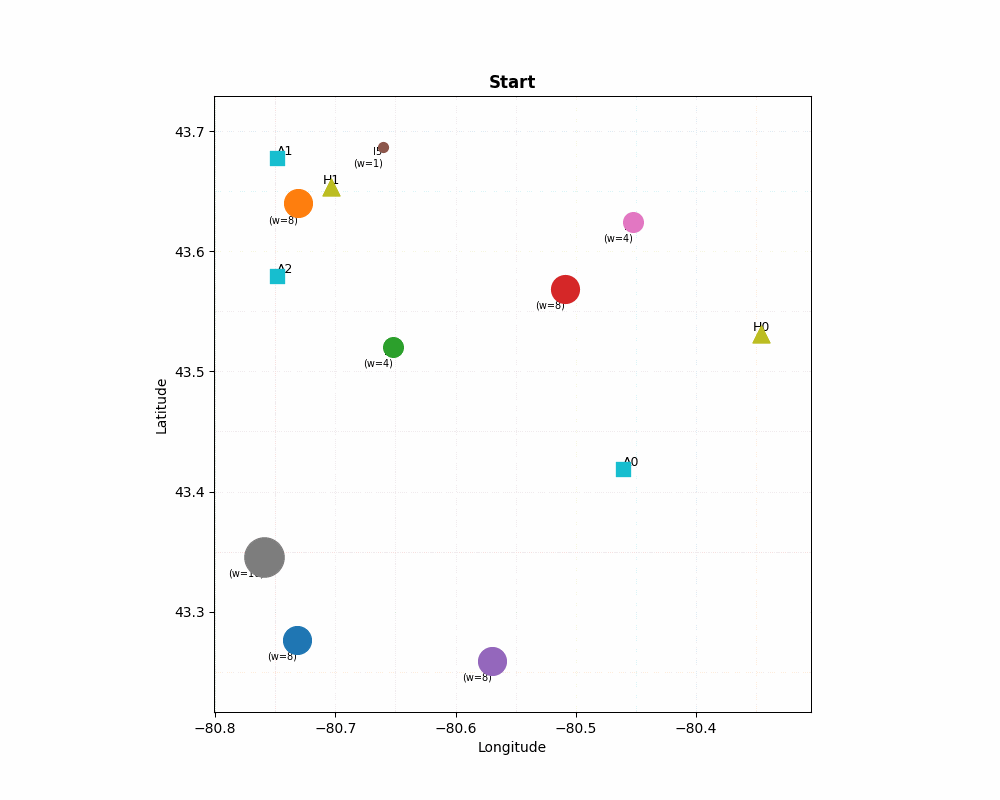

[Saved GIF] ./coord_weighted_ambulance_hospital.gif


In [13]:
# Generate animation with lat/lng coordinates
animate_weighted_dispatch_with_hospitals(
    inst_w,
    hospitals,
    outH_weighted,
    save_path="./coord_weighted_ambulance_hospital.gif",
    fps=0.5
)

In [14]:
# --- cell: animated weighted dispatch with lat/lng ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image as IPyImage, display

def animate_weighted_dispatch_with_hospitals(inst_w, hospitals, outH,
                                            save_path="./weighted_ambulance_hospital_2.gif",
                                            fps=1):
    amb0 = inst_w.coords_ambulances  # (lat, lng)
    inc  = inst_w.coords_incidents   # (lat, lng)
    weights = inst_w.weights
    H    = hospitals  # (lat, lng)
    rounds = outH["rounds"]
    legs   = outH["legs"]
    routes_inc  = outH["routes_incidents"]
    routes_hosp = outH["routes_hospitals"]

    # Build paths for each ambulance
    paths = {}
    for a in range(inst_w.A):
        pts = [amb0[a]]
        for frm, to, kind in legs[a]:
            pts.append(to)
        paths[a] = np.array(pts) if len(pts) else np.array([amb0[a]])

    # Calculate bounds
    all_lats = np.concatenate([amb0[:, 0], inc[:, 0], H[:, 0]])
    all_lngs = np.concatenate([amb0[:, 1], inc[:, 1], H[:, 1]])

    lat_min, lat_max = all_lats.min(), all_lats.max()
    lng_min, lng_max = all_lngs.min(), all_lngs.max()

    lat_pad = (lat_max - lat_min) * 0.1 or 0.02
    lng_pad = (lng_max - lng_min) * 0.1 or 0.02

    lat_min -= lat_pad
    lat_max += lat_pad
    lng_min -= lng_pad
    lng_max += lng_pad

    # Compute positions at each step
    positions = [amb0.copy()]

    def hospital_for(a, j):
        idx = routes_inc[a].index(j)
        return routes_hosp[a][idx]

    for r in rounds:
        prev = positions[-1].copy()
        # Half-step: to incidents
        pos_to_inc = prev.copy()
        for a, j, *_ in r["assignments"]:
            pos_to_inc[a] = inc[j]
        positions.append(pos_to_inc)
        # Half-step: to hospitals
        pos_to_h = pos_to_inc.copy()
        for a, j, *_ in r["assignments"]:
            h_idx = hospital_for(a, j)
            pos_to_h[a] = H[h_idx]
        positions.append(pos_to_h)

    fig, ax = plt.subplots(figsize=(10, 8))
    visited = set()

    def update(step):
        ax.clear()

        # Grid (light)
        lat_grid_step = 0.05
        lng_grid_step = 0.05

        for lat in np.arange(np.floor(lat_min / lat_grid_step) * lat_grid_step,
                            lat_max, lat_grid_step):
            ax.plot([lng_min, lng_max], [lat, lat], linestyle=':', linewidth=0.5, alpha=0.3)

        for lng in np.arange(np.floor(lng_min / lng_grid_step) * lng_grid_step,
                            lng_max, lng_grid_step):
            ax.plot([lng, lng], [lat_min, lat_max], linestyle=':', linewidth=0.5, alpha=0.3)

        # Title
        if step == 0:
            title = "Start"
        else:
            r_num = (step + 1) // 2
            phase = "to incident" if step % 2 == 1 else "to hospital"
            title = f"Round {r_num} — {phase}"

        # Mark visited incidents
        if step > 0 and step % 2 == 1:
            r = rounds[(step + 1)//2 - 1]
            for (a, j, *_) in r["assignments"]:
                visited.add(j)

        # Incidents sized by weight (triangle shaped)
        for i in range(len(inc)):
            alpha = 0.3 if i in visited else 1.0
            size = weights[i] * 50
            ax.scatter([inc[i, 1]], [inc[i, 0]], marker='^', s=size, alpha=alpha, zorder=5)
            ax.text(inc[i, 1], inc[i, 0], f"I{i}\n(w={weights[i]})",
                    va='top', ha='right', fontsize=7)

        # Hospitals (square shaped)
        ax.scatter(H[:, 1], H[:, 0], marker='s', s=150, zorder=5)
        for h in range(len(H)):
            ax.text(H[h, 1], H[h, 0], f"H{h}", va='bottom', ha='center', fontsize=9)

        # Paths up to current step
        for a in range(inst_w.A):
            pts = paths[a]
            legs_done = min(step, len(pts) - 1)
            up_to_idx = 1 + legs_done

            if up_to_idx >= 2:
                # Plot path (lng on x, lat on y)
                ax.plot(pts[:up_to_idx, 1], pts[:up_to_idx, 0],
                        linestyle='-', linewidth=1.5, zorder=3)

                # Label incident points (odd indices: 1, 3, 5, ...)
                label_num = 1
                for idx in range(1, up_to_idx, 2):
                    ax.text(pts[idx, 1], pts[idx, 0], f"{label_num}",
                            va='bottom', ha='left', fontsize=8,
                            bbox=dict(boxstyle='circle,pad=0.1',
                                    facecolor='white', alpha=0.8, edgecolor='black'),
                            zorder=6)
                    label_num += 1

        # Current ambulance positions (circle shaped)
        amb_pos = positions[step]
        ax.scatter(amb_pos[:, 1], amb_pos[:, 0], marker='o', s=100, zorder=5)
        for a in range(len(amb_pos)):
            ax.text(amb_pos[a, 1], amb_pos[a, 0], f"A{a}",
                    va='bottom', ha='left', fontsize=9)

        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlim(lng_min, lng_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_aspect('equal')
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.grid(False)
        return []

    total_steps = 1 + 2 * len(rounds)
    ani = animation.FuncAnimation(fig, update, frames=total_steps,
                                blit=False, interval=1000/fps)
    plt.close(fig)
    ani.save(save_path, writer='pillow', fps=fps)
    display(IPyImage(filename=save_path))
    print(f"[Saved GIF] {save_path}")

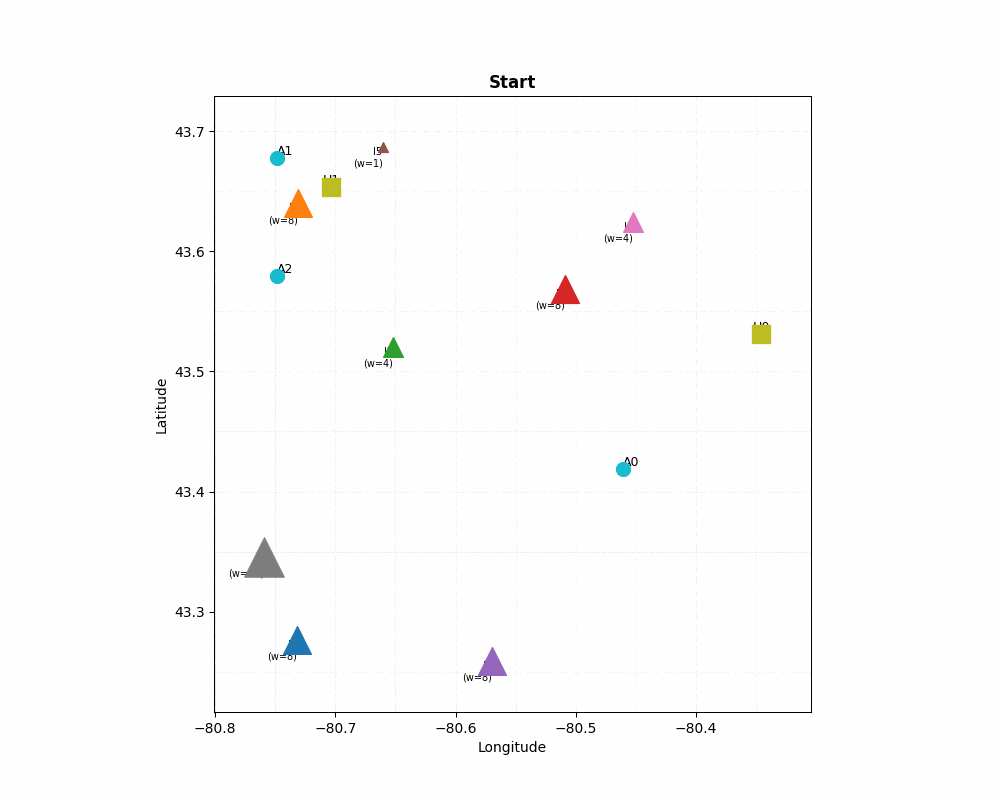

[Saved GIF] ./coord_weighted_ambulance_hospital_2.gif


In [15]:
animate_weighted_dispatch_with_hospitals(
    inst_w,
    hospitals,
    outH_weighted,
    save_path="./coord_weighted_ambulance_hospital_2.gif",
    fps=0.5
)